In [1]:
dnn_attack_intensity = 9

In [2]:
from models.ae import AE
from models.vae import VAE
from models.rnn import RNN
from models.dnn import DNN
from models.dnnAE import DNN as DNNAE


import torch
import torch.nn.functional as F

from sklearn import metrics

import re
import os
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt
from collections import defaultdict
from pandas import DataFrame, concat
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import LinearSegmentedColormap
%matplotlib widget

In [3]:
seed = 37
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Path to all dataset
DATASET_PATH = os.path.join(os.getcwd(), 'data')
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.path.join(os.getcwd(), 'checkpoints')

In [5]:
# vae parameter
latent_dim = 118
# rnn parameter
hidden_size = 100
num_layers = 2
rnn_window = 10
# proposed model parameter
samples = 30
# ae parameter
no_residuals = 1

# predictions
pred = defaultdict(dict)
y = defaultdict()
no_signal = defaultdict()

# **DNN Data Generation**

## **Load Sensor and Residual Data**

In [6]:
Z, RES = defaultdict(dict), defaultdict(dict)
for severity in tqdm(range(5,10), desc='Reading data ... '):
    ATTACK_DATA_PATH = os.path.join(DATASET_PATH, f'I{severity}')
    for filename in os.listdir(ATTACK_DATA_PATH):
        fname = os.path.join(ATTACK_DATA_PATH, filename)
        data = loadmat(fname)
        att_type = int(re.findall(r'\d+', filename)[0])
        Z[severity][att_type] = data['Z']
        RES[severity][att_type] = data['Res']

NORMAL_DATA_FILENAME = 'Normal2.mat'
data = loadmat(os.path.join(DATASET_PATH, NORMAL_DATA_FILENAME))
Z[0] = data['Z']
RES[0] = data['Res']

Z = dict(sorted(Z.items()))
RES = dict(sorted(RES.items()))

Reading data ... : 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


## **Load Trained Models**

In [7]:
noise_levels = [0, 5, 10, 20, 50]
vaes, rnns, aes = dict(), dict(), dict()
# load vae, rnn, ae trained model based on noise levels
for level in noise_levels:
    vae = VAE(latent_dim).to(device, torch.float32)
    vae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'vae_{level}%.pt')))
    vaes[level] = vae

    rnn = RNN(input_dims=rnn_window * latent_dim,
              outputdims=latent_dim,
              hidden_size=hidden_size,
              num_layers=num_layers).to(device, torch.float32)
    rnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'rnn_{level}%.pt')))
    rnns[level] = rnn

    ae = AE(latent_dim).to(device, torch.float32)
    ae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'ae_{level}%.pt')))
    aes[level] = ae

# load dnn and dnnAE trained using normal data and attack severity dnn_attack_intensity attack data
dnn = DNN().to(device, torch.float32)
dnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'dnn_{dnn_attack_intensity}.pt')))

dnnAE = DNNAE(no_residuals=no_residuals).to(device, torch.float32)
dnnAE.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'dnnAE_{dnn_attack_intensity}.pt')))

<All keys matched successfully>

## **VAE+RNN --> DNN Data Generation**

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### **Normal Sensor Data To DNN Data**

In [9]:
pred_normal = defaultdict()
z = torch.tensor(Z[0], dtype=torch.float32).to(device)
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    vae = vaes[level].eval()
    rnn = rnns[level].eval()
    # state estimation residual for normal data
    r1 = torch.tensor(RES[0], dtype=torch.float32)
    R = []
    for _ in range(samples):
        # VAE residuals for normal data
        z_rec = vae(z)
        r2 = (z_rec - z).detach().cpu()

        # rnn prediction residual
        s_t = vae.encoder(z).cpu().detach().numpy()
        s_t = series_to_supervised(s_t, n_in=rnn_window).values[:,:rnn_window * latent_dim]
        s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
        z_rnn = vae.decoder(rnn(s_t))
        r3 = (z_rnn - z[rnn_window:]).detach().cpu()
        R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
    pred_normal[level] = dnn(torch.stack(R, dim=1).to(device)).detach().cpu()

 Generating residuals ... : 100%|██████████| 5/5 [00:23<00:00,  4.62s/it]


### **Attack Sensor Data To DNN Data**

In [10]:
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    vae = vaes[level].eval()
    rnn = rnns[level].eval()
    for severity in range(5,10):
        _Z, _RES = Z[severity], RES[severity]
        R = defaultdict(list)
        for k, v in _Z.items():
            # state estimation residual
            r1 = torch.tensor(_RES[k], dtype=torch.float32)
            z = torch.tensor(v, dtype=torch.float32).to(device)
            _R = []
            for _ in range(samples):
                # VAE residuals
                z_rec = vae(z)
                r2 = (z_rec - z).detach().cpu()
                
                # rnn prediction residual
                s_t = vae.encoder(z).cpu().detach().numpy()
                s_t = series_to_supervised(s_t, n_in=rnn_window).values[:,:rnn_window * latent_dim]
                s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
                z_rnn = vae.decoder(rnn(s_t))
                r3 = (z_rnn - z[rnn_window:]).detach().cpu()
                _R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
            R[k] = torch.stack(_R, dim=1)
        R = dict(sorted(R.items()))
        _pred = dnn(torch.cat(list(R.values()), dim=0).to(device))
        pred['vae'][level,severity] = torch.cat([pred_normal[level].cpu(), _pred.cpu()], dim=0).detach()

 Generating residuals ... : 100%|██████████| 5/5 [05:18<00:00, 63.66s/it]


### **Target Data**

In [11]:
_y = []
no_signal['vae'] = len(Z[0]) - rnn_window
for l in range(4):
    _y.append(F.one_hot(l * torch.ones((no_signal['vae']), dtype=torch.long), num_classes=4))
y['vae'] = torch.cat(_y, dim=0)

## **AE --> DNN Data Generation**

### **Normal Sensor Data To DNN Data**

In [12]:
pred_normal = defaultdict()
z = torch.tensor(Z[0], dtype=torch.float32).to(device)
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    ae = aes[level].eval()
    # AE residuals for normal data
    r = (ae(z) - z)
    pred_normal[level] = dnnAE(torch.stack([r], dim=1)).detach().cpu()

 Generating residuals ... : 100%|██████████| 5/5 [00:00<00:00, 887.83it/s]


### **Attack Sensor Data To DNN Data**

In [13]:
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    ae = aes[level].eval()
    for severity in range(5,10):
        _Z = Z[severity]
        R = defaultdict(list)
        for k, v in _Z.items():
            z = torch.tensor(v, dtype=torch.float32).to(device)
            # AE residuals
            r = (ae(z) - z).detach().cpu()
            R[k] = torch.stack([r], dim=1)
        R = dict(sorted(R.items()))
        _pred = dnnAE(torch.cat(list(R.values()), dim=0).to(device))
        pred['ae'][level,severity] = torch.cat([pred_normal[level].cpu(), _pred.cpu()], dim=0).detach()

 Generating residuals ... : 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]


### **Target Data**

In [14]:
_y = []
no_signal['ae'] = len(Z[0])
for l in range(4):
    _y.append(F.one_hot(l * torch.ones((no_signal['ae']), dtype=torch.long), num_classes=4))
y['ae'] = torch.cat(_y, dim=0)

# **DNN Evaluation**

## **Detection-Localozation Accuracy**

In [15]:
detection, localization = defaultdict(list), defaultdict(list)
for k in pred.keys():
    for severity in range(5,10):
        for level in noise_levels:
            pp = torch.argmax(pred[k][level,severity], dim=1).numpy()
            yy = torch.argmax(y[k], dim=1).numpy()
            localization[k, severity].append(metrics.accuracy_score(yy, pp))
            yy[yy>0] = 1
            pp[pp>0] = 1
            detection[k, severity].append(metrics.accuracy_score(yy,pp))

### **Detection**

In [16]:
severity = list(range(5,10))
x = np.arange(len(noise_levels))
y = np.arange(len(severity))
X, Y = np.meshgrid(x, y)
x_ax = ['0%', '%5', '%10', '%20', '50%']
z_vae = np.zeros((len(severity), len(x_ax)))
z_ae = np.zeros((len(severity), len(x_ax)))
for s in severity:
    for n in x:
        z_vae[s-5,n] = detection['vae',s][n]
        z_ae[s-5,n] = detection['ae',s][n]

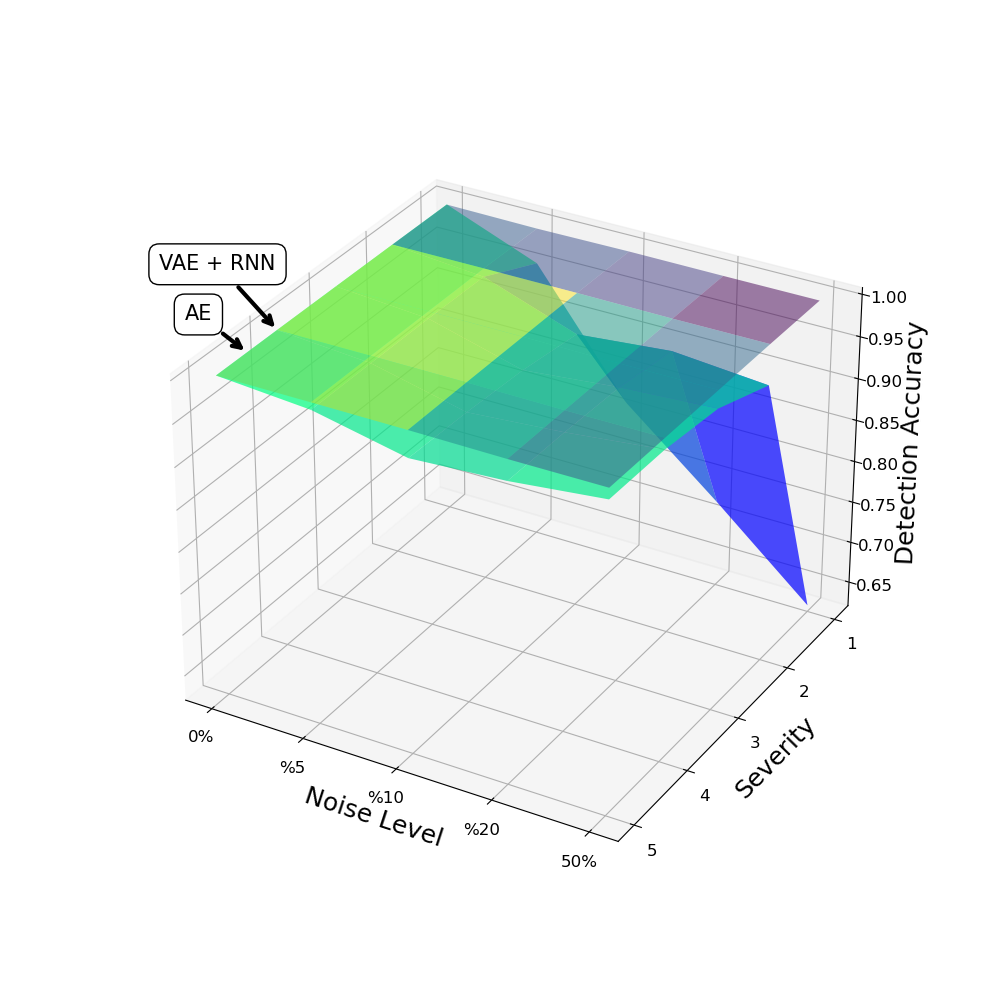

In [17]:
y_ax = list(range(1,6))
y_ax.reverse()
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, z_vae, cmap="viridis", alpha = 0.5, label="VAE+RNN")
ax.plot_surface(X, Y, z_ae, cmap="winter", alpha = 0.7, label='AE')
ax.tick_params(axis='both', which='major', labelsize=12, width=2)

x2, y2, _ = proj3d.proj_transform(0,1,1, ax.get_proj())
label = plt.annotate(
    "VAE + RNN", 
    xy = (x2, y2), xytext = (-1, 40), fontsize=15,
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white'),
    arrowprops = dict(arrowstyle = '->', lw=3, connectionstyle = 'arc3,rad=0'))

x2, y2, _ = proj3d.proj_transform(0,0.5,1, ax.get_proj())
label = plt.annotate(
    "AE", 
    xy = (x2, y2), xytext = (-25, 20), fontsize=15,
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white'),
    arrowprops = dict(arrowstyle = '->', lw=3, connectionstyle = 'arc3,rad=0'))

ax.xaxis.set_major_locator(mticker.MaxNLocator(len(noise_levels)))
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc[:-1]))
ax.set_xticklabels([0] + x_ax, ha='center')

ax.yaxis.set_major_locator(mticker.MaxNLocator(len(severity)))
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc[:-1]))
ax.set_yticklabels([0] + y_ax, ha='center')
ax.set_xlabel("Noise Level", fontsize=18)
ax.set_ylabel("Severity", fontsize=18)
ax.set_zlabel("Detection Accuracy", rotation=90, fontsize=18)
plt.show()
# plt.close()

### **Localization**

In [18]:
severity = list(range(5,10))
x = np.arange(len(noise_levels))
y = np.arange(len(severity))
X, Y = np.meshgrid(x, y)
x_ax = ['0%', '%5', '%10', '%20', '50%']
z_vae = np.zeros((len(severity), len(x_ax)))
z_ae = np.zeros((len(severity), len(x_ax)))
for s in severity:
    for n in x:
        z_vae[s-5,n] = localization['vae',s][n]
        z_ae[s-5,n] = localization['ae',s][n]

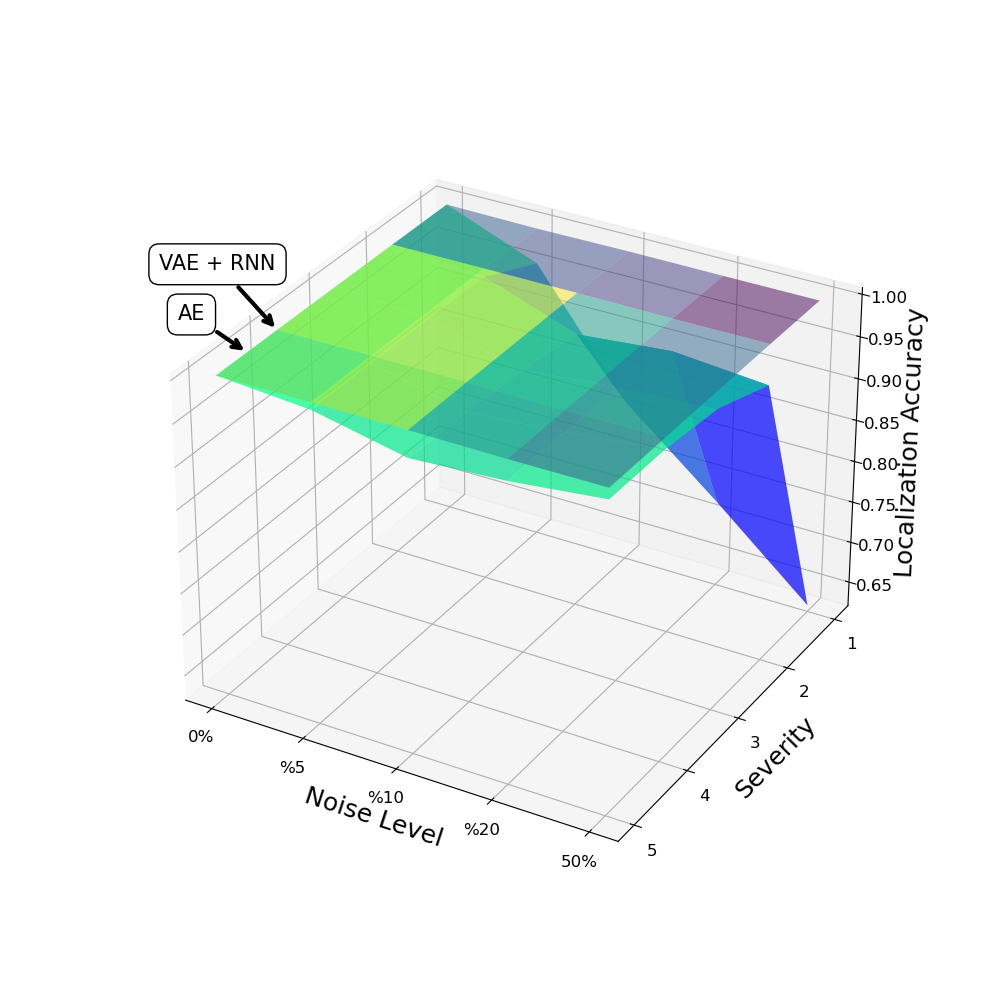

In [19]:
y_ax = list(range(1,6))
y_ax.reverse()
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, z_vae, cmap="viridis", alpha = 0.5, label="VAE+RNN")
ax.plot_surface(X, Y, z_ae, cmap="winter", alpha = 0.7, label='AE')
ax.tick_params(axis='both', which='major', labelsize=12, width=2)

x2, y2, _ = proj3d.proj_transform(0,1,1, ax.get_proj())
label = plt.annotate(
    "VAE + RNN", 
    xy = (x2, y2), xytext = (-1, 40), fontsize=15,
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white'),
    arrowprops = dict(arrowstyle = '->', lw=3, connectionstyle = 'arc3,rad=0'))

x2, y2, _ = proj3d.proj_transform(0,0.5,1, ax.get_proj())
label = plt.annotate(
    "AE", 
    xy = (x2, y2), xytext = (-30, 20), fontsize=15,
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white'),
    arrowprops = dict(arrowstyle = '->', lw=3, connectionstyle = 'arc3,rad=0'))

ax.xaxis.set_major_locator(mticker.MaxNLocator(len(noise_levels)))
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc[:-1]))
ax.set_xticklabels([0] + x_ax, ha='center')

ax.yaxis.set_major_locator(mticker.MaxNLocator(len(severity)))
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc[:-1]))
ax.set_yticklabels([0] + y_ax, ha='center')
ax.set_xlabel("Noise Level", fontsize=18)
ax.set_ylabel("Severity", fontsize=18)
ax.set_zlabel("Localization Accuracy", rotation=90, fontsize=18)
plt.show()
# plt.close()